### Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib import colors
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, StratifiedKFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay                       

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from shapely.geometry import Polygon
from shapely.geometry import Point
import random

from re import compile

## Step 1 - Geocoding

After importing `manh_tickets_2019.csv.zip` and `manh_pluto.csv` as `tix` and `pluto`, we first standardized the case of the data by capitalizing the address in both datasets. 

Our next step is to standardize the expressions of address by changing the abbreviations into full words. We stored all expressions that need to be changed in `rep_dict`. We noticed that "AVE", "ST" are two of the most common abbreviations that are recorded differently among the two datasets. From observation, the `tix` dataset generally uses abbreviations such as "AVE" and "ST", while the `pluto` dataset contains both the full word as well as abbreviations. To ensure accuracy, we will perform the string replacement on both datasets at the cost of a longer run time. There are also several other location abbreviations such as "PL" and "AMER" that need to be changed. The full list can be viewed in code for `rep_dict` below. In order to make replacements only on abbreviations, we detected the abbreviated suffixes by checking whether it is bounded in front by a whitespace, and followed by either a white space or the end of the line. We also performed similar procedures on directional abbreviations "S", "N", "W", "E" and changed them into full words. We also removed ordinal expressions such as "1st", "2nd" and replace them with plain numbers. We decided to do this since there were inconsistencies in how numbered streets (for ex.) were named between the two dataframes, so regex-ing would require more complicated processing of each of the cases, so instead we just string matched for 'TH', 'ST', 'ND' in which a digit occurs right before it and deleted it. We then use `rep_dict` to standardize the wording on the address of the two datasets by using `pd.replace()`

We removed duplicates in the `tix` dataset using `address` and `precinct` and then filtered out any rows in which an address belongs to multiple precincts. 

Finally, we merged `pluto` to `tix` to obtain the geocoded addresses. 

In [2]:
# read the data
tix = pd.read_csv("data/manh_tickets_2019.csv.zip")
pluto = pd.read_csv("data/manh_pluto.csv")

In [3]:
# capitalize address in both datasets
tix.address = tix.address.str.upper()
pluto.address = pluto.address.str.upper()

In [4]:
# use compile to produce possible similar address expressions
rep_dict = {
    compile(r'(?<=\s)AVE(?=\s|$)'): 'AVENUE',
    compile(r'(?<=\s)ST(?=\s|$)'): 'STREET',
    compile(r'(?:(?<=\s)|(?<=^))S(?=\s|$)'): 'SOUTH',
    compile(r'(?:(?<=\s)|(?<=^))N(?=\s|$)'): 'NORTH',
    compile(r'(?:(?<=\s)|(?<=^))W(?=\s|$)'): 'WEST',
    compile(r'(?:(?<=\s)|(?<=^))E(?=\s|$)'): 'EAST',
    compile(r'(?<=\d)ST'): '',
    compile(r'(?<=\d)ND'): '',
    compile(r'(?<=\d)RD'): '',
    compile(r'(?<=\d)TH'): '',
    compile(r'(?<=\s)PL(?=\s|$)'): 'PLACE',
    compile(r'(?<=\s)PLCE(?=\s|$)'): 'PLACE',
    compile(r'(?<=\s)AMER(?=\s|$)'): 'AMERIC',
    compile(r'(?<=\s)DR(?=\s|$)'): 'DRIVE',
    compile(r'(?<=\s)SQ(?=\s|$)'): 'SQUARE',
    compile(r'(?<=\s)PLZ(?=\s|$)'): 'PLAZA',
    'F D R': 'FDR',
    compile(r'(?<=\s)BLVD(?=\s|$)'): 'BOULEVARD',
    compile(r'(?<=\s)TER(?=\s|$)'): 'TERRACE'  
}

In [5]:
# replace address in both datasets with the compile 
tix.address = tix.address.replace(rep_dict, regex=True)
pluto.address = pluto.address.replace(rep_dict, regex = True)

In [6]:
# take out addresses that belong to different precincts or duplicates
tix_sub = tix[['address', 'precinct']].copy()
tix_sub.drop_duplicates(inplace=True)
tix_sub = tix_sub.groupby('address').filter(lambda x: len(x) == 1)

In [7]:
# merge the data with same address
tix_geo = pd.merge(tix_sub, pluto, how="inner", on='address')

## Step 2 - Modeling

First, we added data for precinct 22 by creating a polygon bounded by the border of central park coordinates and randomly sampling from that polygon. The coordinates of central park were approximated by looking at the border of the park via Google Maps. The function to randomly sample the polygon is inspired by a stack exchange post (https://gis.stackexchange.com/questions/294394/randomly-sample-from-geopandas-dataframe-in-python) where the x,y coordinates are randomly uniformly sampled and in a rejection sampling method, the sampled points are kept only if it is contained within the central park constructed polygon. We sampled 1,000 points since precincts have around the number of points post-cleaning on average. Then we took the x,y coordinates from the 1,000 Point objects and stored them into a dataframe in addition to a `precinct` column all with value 22. Finally, we concatenated the data into the final merged results from Task 1. 

To begin our model training, we first split the training data into test and training into 1/3 and 2/3 partitions, respectively, using `test_train_split()`. We did this with `stratify` argument as our labels, so that the test-train split would preserve the proportion of precincts. As for the training dataset, we performed cross-validation by performing stratified k-fold (which would similarly preserve the prop. of precincts for each fold) with k = 5 and utilized performance on the validation set to compare different models and choose the best hyperparameters. We decided to use 'accuracy' as the metric for model tuning because it is very intuitive and straightforward. Furthermore, there are very few classes with just a couple of precincts. In this case, 'accuracy' would not tend to hide strong classification errors for classes with few units.

For the models that we tried, we first started with SVC but we decided not to use the model because the runtime was longer than the 60-minute stipulation. The models we trained on were multi-class logistic regression, decision tree/random forest, and K-nearest neighbors. Out of these three, logistic regression performed by far the worst (the best performing estimator had an accuracy of merely 0.6). Random forest and KNN performed similarly well, but KNN performed slightly better and was a little bit faster in training. From the cross-validation, the best estimator for RF had an accuracy of 0.951 while KNN had 0.957. Therefore, we chose KNN as our top-performing model. 

In terms of hyperparameters tuned, for random forest, we tuned on `criterion` (either entropy or gini), a range of `max_depth` between 2 and 10, and a range of `min_samples_split` between 2 and 10. The best estimator for the random forest classifier had hyperparameters: criterion = 'entropy', max_depth = 9, min_samples_split = 6. For KNN, we tuned on `leaf_size` with a range between 1 and 25, `n_neighbors` between 3 and 30, and weights (either uniform or distance). When selecting the value range for `n_neighbors`, we considered that too few n_neighbors would cause overfitting, and too many `n_neighbors` would cause underfitting. In that way, we set the final value range of `n_neighbors` to be between 3 and 30. Therefore, our best model is KNN, with best tuned hyperparameters:  n_neighbors = 8, weights = 'distance', leaf_size = 1. 

Using the best-tuned estimators, we fit a KNN model on the entire training set and then used the model to predict the test data set. We evaluated performance of our best training model on test data with `classification_report()` and `confusion_matrix()`. 

In the `classification_report()`, precision, recall, f1 score, and accuracy are all adequately high to substantiate that our training model has a great performance on the test data. The most critical indexes are accuracy (0.95), f1-score macro avg (0.92), and f1-score weighted avg (0.95). As for `confusion_matrix()`, all the numbers in the diagonal represent the number of accurately classified samples, which obviously outweigh the numbers of inaccurately classified samples. 

In [8]:
# add precinct 22, central park 
lat_point_list = [40.768118190197676, 40.76445932336382, 40.796976472355176, 40.80057478867638, 40.768118190197676]
lon_point_list = [-73.98187713724504, -73.97308890802097, -73.94919771307822, -73.95822904655219, -73.98187713724504]

# https://gis.stackexchange.com/questions/294206/how-to-create-a-simple-polygon-from-coordinates-in-geopandas-with-python
polygon_geom = Polygon(zip(lon_point_list, lat_point_list))  

In [9]:
# https://gis.stackexchange.com/questions/294394/randomly-sample-from-geopandas-dataframe-in-python
def random_points_in_polygon(number, polygon):
    points = []
    min_x, min_y, max_x, max_y = polygon.bounds
    i= 0
    while i < number:
        point = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
        if polygon.contains(point):
            points.append(point)
            i += 1
    return points 

In [10]:
# add points to precinct 22
points = random_points_in_polygon(1000, polygon_geom)
lat_22 = []
long_22 = []

for point in points:
    lat_22.append(point.y)
    long_22.append(point.x)
    
coord_22 = pd.DataFrame({'lat':lat_22, 'long':long_22, 'precinct':22})

In [11]:
# split into training and test data 
X = pd.concat([tix_geo.loc[:, 'lat':'long'], coord_22.loc[:, 'lat':'long']])
y = pd.concat([tix_geo.loc[:, 'precinct'], coord_22.loc[:, 'precinct']])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.33, shuffle = True, random_state = 1234, stratify=y
)

In [12]:
# find the KNN model with best hyperparameters 
n_digits = np.unique(y).size

knn_cv = GridSearchCV(
    KNeighborsClassifier(),
    param_grid = {
        "n_neighbors": np.arange(3, 30),
        "weights": ["uniform", "distance"],
        "leaf_size": np.arange(1, 25),
    }, 
    cv= StratifiedKFold(5, shuffle = True, random_state = 12345),
    n_jobs = -1
).fit(X_train, y_train)

In [13]:
# find the best model and accuracy on validation set
print(knn_cv.best_estimator_)
print()
print(knn_cv.best_score_)

KNeighborsClassifier(leaf_size=1, n_neighbors=8, weights='distance')

0.9565912563899632


In [14]:
# train the best model on the entire training set 
knn_best = KNeighborsClassifier(n_neighbors = 8, weights = 'distance', leaf_size = 1)
knn_best.fit(X_train, y_train)

KNeighborsClassifier(leaf_size=1, n_neighbors=8, weights='distance')

In [15]:
# work product 1: classification report
print(classification_report(y_test, knn_best.predict(X_test)))

              precision    recall  f1-score   support

           1       0.96      0.97      0.97       221
           5       0.97      0.98      0.97       176
           6       0.99      0.99      0.99       472
           7       0.97      0.97      0.97       119
           9       0.99      0.99      0.99       384
          10       0.86      0.90      0.88        86
          13       0.94      0.92      0.93       149
          14       0.90      0.72      0.80        64
          17       0.90      0.93      0.92       120
          18       0.94      0.94      0.94       125
          19       0.99      0.99      0.99      1004
          20       0.99      0.96      0.97       351
          22       0.99      1.00      0.99       330
          23       0.96      0.91      0.94       149
          24       0.93      0.97      0.95       177
          25       0.88      0.94      0.91       124
          26       0.84      0.65      0.73        40
          28       0.93    

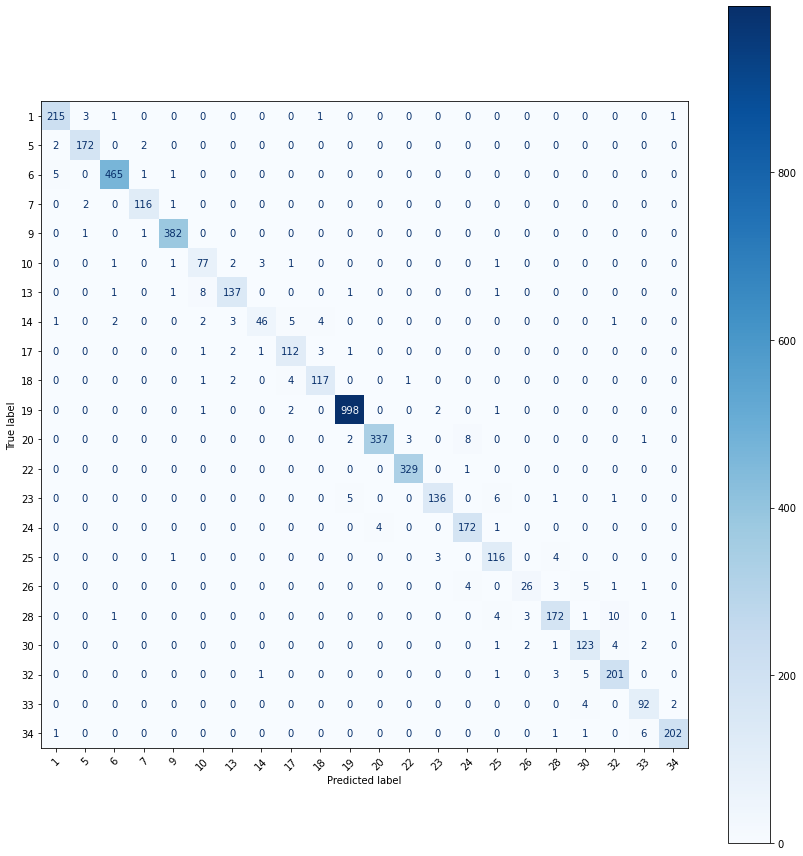

In [16]:
# work product 2: confusion matrix visualization
cm = confusion_matrix(y_test, knn_best.predict(X_test))
label= [1, 5, 6, 7, 9, 10, 13, 14, 17, 18, 19, 20, 22, 23, 24, 25, 26, 28, 30, 32, 33, 34]
fig, ax = plt.subplots(figsize = (12,12))
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = label)
disp.plot(cmap = plt.cm.Blues, xticks_rotation = 45, ax = ax)
plt.tight_layout()
plt.show()

## Step 3 - Visualization

In [17]:
# read the data
pred = pd.read_csv("data/manh_pred.csv")
bound = pd.read_csv("data/manh_bound.csv")

In [18]:
# predict using selected model 
res = knn_best.predict(pred[['lat', 'long']])

# make dataframe of results, and concatenate to pred dataframe
res = pd.DataFrame({'res':res})
pred_res = pd.concat([pred, res], axis=1)

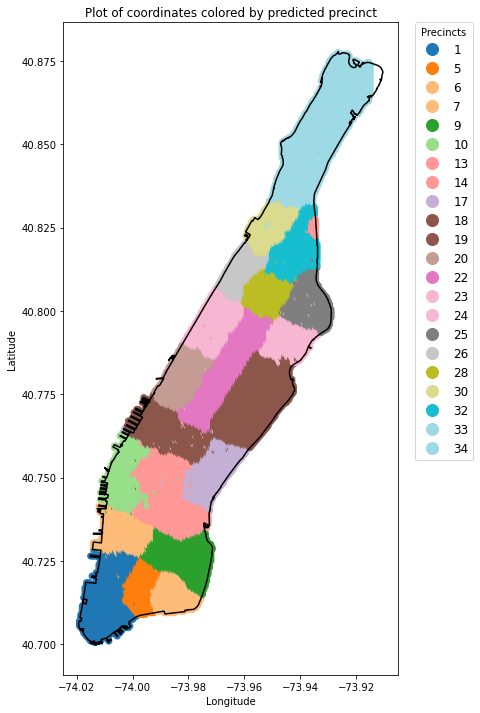

In [19]:
# elongate vertical axis 
plt.figure(figsize=(6, 12))

# plot manhattan border
plt.plot(bound.long, bound.lat, color='black')

# plot prediction points 
cmap = get_cmap('tab20')
sc = plt.scatter(pred_res.long, pred_res.lat, c=pred_res.res, cmap=cmap)

# add legend for precincts (https://stackoverflow.com/questions/38234115/pandas-matplotlib-pyplot-add-legend-by-a-column-value)
lp = lambda i: plt.plot([],color=cmap(sc.norm(i)), 
                        label="{:g}".format(i), ls="", marker="o")[0]
handles = [lp(i) for i in np.unique(pred_res.res)]
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Precincts",
          markerscale=2, fontsize = 12)
    
# labels
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Plot of coordinates colored by predicted precinct")

plt.show()